In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# load mnist
train_ds = MNIST('data', train=True, download=True, transform=ToTensor())
test_ds = MNIST('data', train=False, download=True , transform=ToTensor())

# create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=12)
val_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=12)

sample = next(iter(train_loader))

In [29]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, latent_dim, 1, padding=0)
        )

    def forward(self, x):
        return self.encoder(x)


In [74]:
rand = torch.randn(32, 1, 28, 28)

encoder = Encoder()

print(encoder(rand).shape)

torch.Size([32, 16, 7, 7])


In [46]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, padding=1)
        )

    def forward(self, x):
        return self.decoder(x)

In [66]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        w_init = torch.nn.init.uniform_
        self.embeddings = nn.Parameter(w_init(torch.empty(self.embedding_dim, self.num_embeddings)))
        
    def forward(self, x):
        input_shape = x.shape
        flattened = x.view(-1, self.embedding_dim)

        encoding_indices = self.get_code_indices(flattened)
        encodings = F.one_hot(encoding_indices, num_classes=self.num_embeddings).to(flattened.device)
        quantized = torch.matmul(encodings.float(), self.embeddings.t())

        quantized = quantized.view(input_shape)

        commitment_loss = torch.mean((quantized.detach() - x) ** 2)
        codebook_loss = torch.mean((quantized - x.detach()) ** 2)
        self.loss = self.beta * commitment_loss + codebook_loss

        quantized = x + (quantized - x).detach()
        return quantized, self.loss, encoding_indices

    def get_code_indices(self, flattened_inputs):
        similarity = torch.matmul(flattened_inputs, self.embeddings)
        distances = (torch.sum(flattened_inputs ** 2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings ** 2, dim=0)
                     - 2 * similarity)

        encoding_indices = torch.argmin(distances, dim=1)
        return encoding_indices

In [68]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super(VQVAE, self).__init__()
        self.encoder = Encoder()
        self.vq = VectorQuantizer(num_embeddings, embedding_dim, beta)
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        z_q, loss, codes = self.vq(z)
        x_hat = self.decoder(z_q)

        loss = loss + F.mse_loss(x_hat, x)
        
        return x_hat, loss, codes

model = VQVAE(128, 16)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, train_loader, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x_hat, loss, codes = model(x)
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f'Epoch {epoch}, iter {i}, loss {loss.item():.4f}')


In [69]:
train(model, train_loader, optimizer, num_epochs=5)

Epoch 0, iter 0, loss 0.5199
Epoch 0, iter 100, loss 0.2173
Epoch 0, iter 200, loss 0.1400
Epoch 0, iter 300, loss 0.1368
Epoch 0, iter 400, loss 0.1137
Epoch 0, iter 500, loss 0.1015
Epoch 0, iter 600, loss 0.1027
Epoch 0, iter 700, loss 0.1027
Epoch 0, iter 800, loss 0.0946
Epoch 0, iter 900, loss 0.0932
Epoch 0, iter 1000, loss 0.1031
Epoch 0, iter 1100, loss 0.0851
Epoch 0, iter 1200, loss 0.0795
Epoch 0, iter 1300, loss 0.0948
Epoch 0, iter 1400, loss 0.0779
Epoch 0, iter 1500, loss 0.0825
Epoch 0, iter 1600, loss 0.0743
Epoch 0, iter 1700, loss 0.0777
Epoch 0, iter 1800, loss 0.0696
Epoch 1, iter 0, loss 0.0698
Epoch 1, iter 100, loss 0.0633
Epoch 1, iter 200, loss 0.0609
Epoch 1, iter 300, loss 0.0694
Epoch 1, iter 400, loss 0.0697
Epoch 1, iter 500, loss 0.0629
Epoch 1, iter 600, loss 0.0604
Epoch 1, iter 700, loss 0.0713
Epoch 1, iter 800, loss 0.0710
Epoch 1, iter 900, loss 0.0630
Epoch 1, iter 1000, loss 0.0610
Epoch 1, iter 1100, loss 0.0591
Epoch 1, iter 1200, loss 0.0618


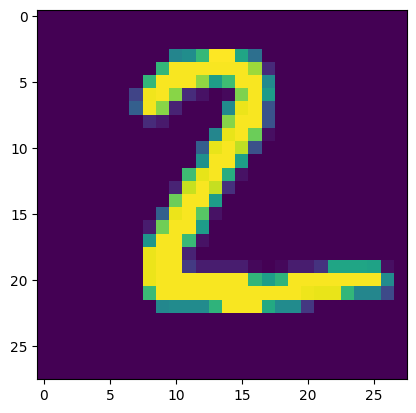

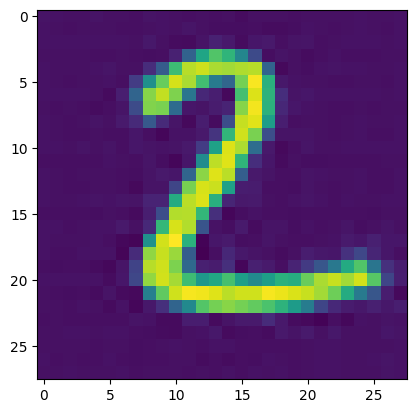

torch.Size([1568])


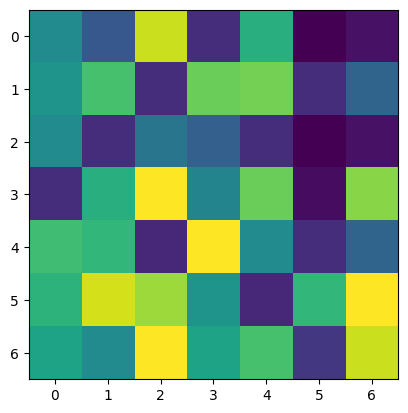

In [77]:
#save model to file
torch.save(model.state_dict(), 'vq_vae.pth')

#print reconsturction and original image
x, _ = next(iter(val_loader))

x_hat, _, codes = model(x)

import matplotlib.pyplot as plt
plt.imshow(x[1, 0])
plt.show()
plt.imshow(x_hat[1, 0].detach())
plt.show()

print(codes.shape)

# reshape to 32*7*7

codes = codes.view(32, 7, 7)

# print codes

plt.imshow(codes[1])
